In [142]:
import json
from haralyzer import HarParser, HarPage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Extract websocket data from Har to JSON

In [126]:
class ProcHarData:
    
    def __init__(self,har_filename):
        self.harfile = har_filename
    
    def convHar2Json(self):
        with open(self.harfile, 'r') as f:
            har_parser = HarParser(json.loads(f.read()))

        data = har_parser.har_data
        ws_entries = []
        entries = []
        dict_data = {}
        for entry in har_parser.har_data["entries"]:
            if '_webSocketMessages' in entry.keys():
                ws_entries = entry['_webSocketMessages']
                break

        for ws_entry in ws_entries:    
            if ws_entry['data'].startswith("{"):
                data = json.loads(ws_entry['data'])
                if data['type'] == 3:
                    ws_entry['data'] = data
                    entries.append(ws_entry)
        dict_data['WS'] = entries
        json_filename = "data/data_" + datetime.now().strftime("%m-%d-%Y_%H:%M:%S") + ".json"
        with open(json_filename, 'w') as fp:
            json.dump(dict_data, fp)
        return json_filename


    def convJson2DF(self, json_filename=None):
        if json_filename:
            df = pd.read_json(json_filename)
        else:
            df = pd.read_json(self.convHar2Json())
        time = []
        duration = []
        for idx,row in df.iterrows():
            time.append(row['WS']['time'])
            durms = round(row['WS']['data']['data']['duration']/1000,2)
            duration.append(durms)
        df['DateTime'] = time
        df['TSDuration(ms)'] = duration
        df['DateTime'] = pd.to_datetime(df['DateTime'],unit='s')
        df = df.sort_values(by='DateTime')
        
        return df
    
    def plotTS(self,df1):
        
        fig, ax = plt.subplots(figsize=(12,5))
        meanDur = np.full(len(df1),df1.mean().values)
        df1.plot(figsize=(18,5),title='Tip Selection Duration(ms)',xlabel='Timesteps',ylabel='Duration(ns)',ax=ax)
        ax.plot(meanDur,'r')

        fig.show()

    TSDuration(ms)
0            42.78
1             2.44
2             9.47
3             4.47
4             3.34
..             ...
95            9.13
96            3.28
97            7.32
98            2.95
99            6.26

[100 rows x 1 columns]


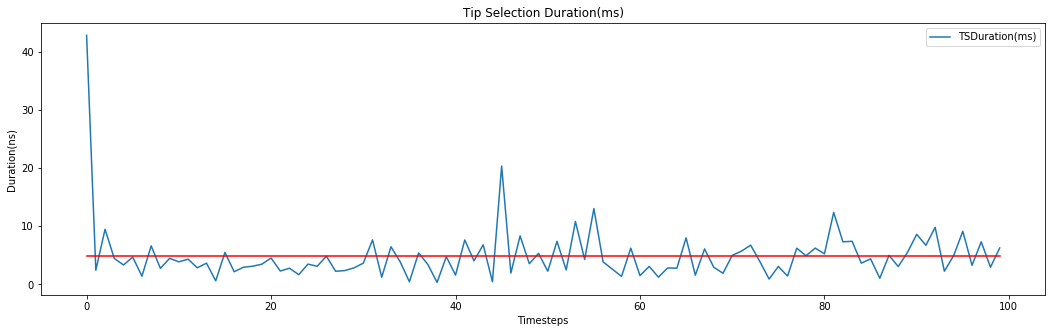

In [129]:
filename = 'data/10.2.8.177.har'
har = ProcHarData(filename)
df = har.convJson2DF()

df1 = df[['TSDuration(ms)']][:100]
print(df1)
har.plotTS(df1)

# Process locust perf data

In [203]:
class ProcLocustData:
    
    def __init__(self,locustdata_file):
        self.locustfile = locustdata_file
    
    
    def load2DF(self):
        """
        load data and return statistics dataframe.
        -----------------------
        Parameters:
            locustdata_file: string
                path and filename
        
        Returns:
            df_statics: DataFrame
                Statistics (mean values) dataframe of a specific task.
        -----------------------
        """
        df = pd.read_csv(self.locustfile)
        df.dropna(inplace=True)
        df = df.loc[(df['User Count'] % 10 == 0) & (df['User Count'] != 0)]
        
        return df
    
    
    def plotER(self,df,name):
        
        fig=plt.figure()

        ax1 = df[['Total Average Response Time']].plot(marker='*',legend=False)
        ax2 = df['Requests/s'].plot(secondary_y=True, marker='o')
        ax1.set_ylabel('Mean Response Time(ms)')
        ax2.set_ylabel('Requests/s')

        handles,labels = [],['E[R]','$\lambda$']
        for ax in [ax1,ax2]:
            for h,_ in zip(*ax.get_legend_handles_labels()):
                handles.append(h)

        plt.legend(handles,labels,loc='upper left')

        plt.title('Mean Response Time against User Count ({})'.format(name))
        plt.show()

In [204]:
def plotAll(filename):
    locust = ProcLocustData(filename)
    df = locust.load2DF()
    for name in df.Name.unique():
        df_task = df.loc[df['Name']==name]
        df_statics = df_task.groupby(by='User Count').mean()
        locust.plotER(df_statics,name)

<Figure size 432x288 with 0 Axes>

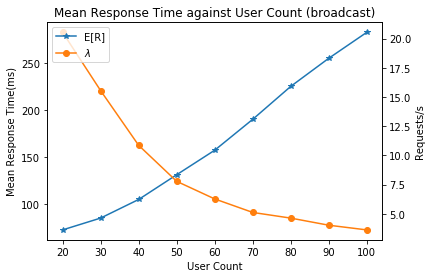

<Figure size 432x288 with 0 Axes>

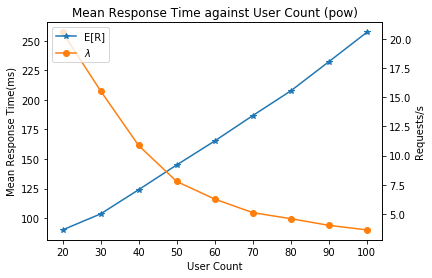

<Figure size 432x288 with 0 Axes>

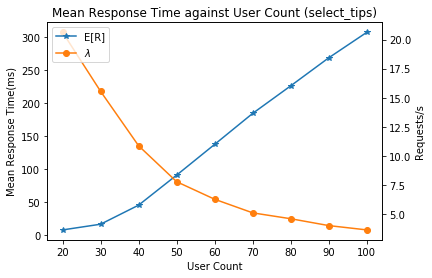

<Figure size 432x288 with 0 Axes>

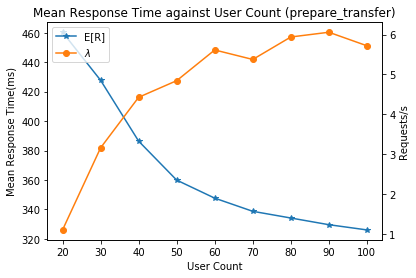

<Figure size 432x288 with 0 Axes>

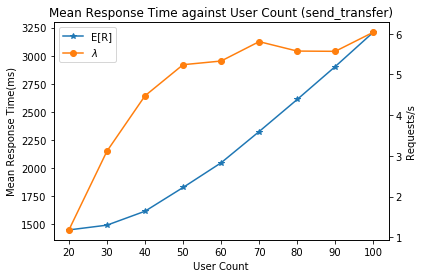

<Figure size 432x288 with 0 Axes>

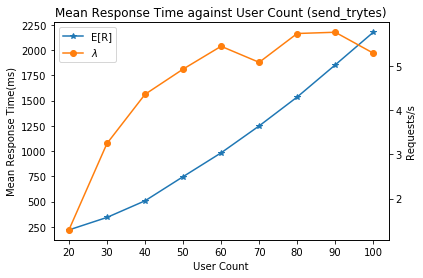

In [198]:
filename = 'data/example_stats_history(120s-20to100)w prepare.csv'
plotAll(filename)

<Figure size 432x288 with 0 Axes>

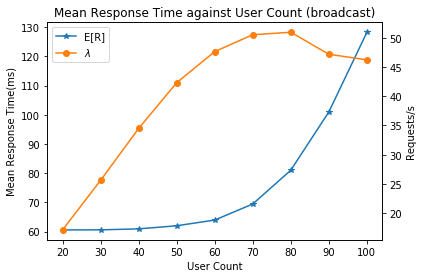

<Figure size 432x288 with 0 Axes>

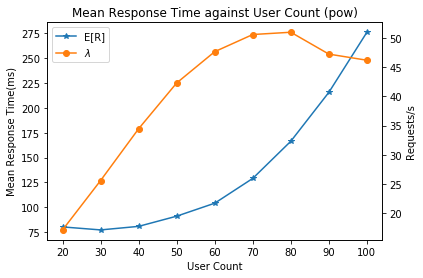

<Figure size 432x288 with 0 Axes>

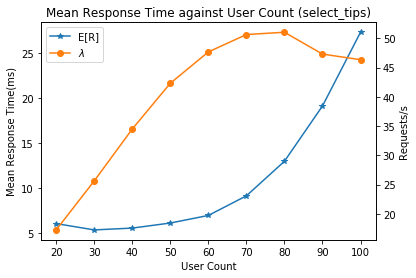

In [210]:
filename = 'data/requests_full_history_1620626618.3389308 (1).csv'
plotAll(filename)

<Figure size 432x288 with 0 Axes>

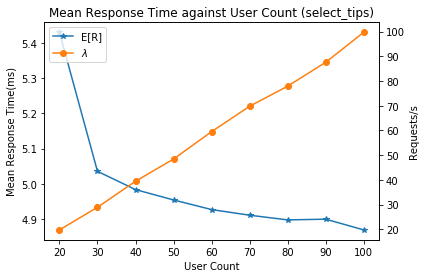

In [211]:
filename = 'data/requests_full_history_1620664510.9175324.csv'
plotAll(filename)

<Figure size 432x288 with 0 Axes>

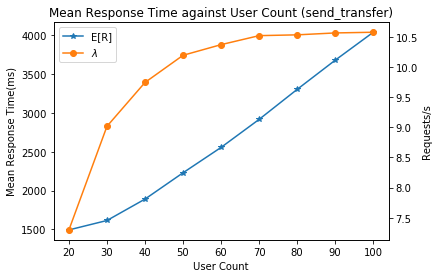

In [212]:
filename = 'data/requests_full_history_1620666204.3876286.csv'
plotAll(filename)